In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **LIBRARIES**

In [2]:
%%capture
!pip install catboost
!pip install pycountry
!pip install pycountry-convert

In [3]:
import warnings, itertools, random, os, re, gc, time
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# **DATA IMPORT**

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Zindi - ai4d lab tanzania tourism classification challenge/"
save_path = path + "sub/"

country_err = {
  'Bosnia': 'Bosnia and Herzegovina',
  'Burgaria': 'Bulgaria',
  'Cape Verde': 'Cabo Verde',
  'Comoro': 'Comoros',
  'Costarica': 'Costa Rica',
  'Czech Republic': 'Czechia', 
  'Djibout': 'Djibouti', 
  'Drc': 'Congo', 
  'Ecuado': 'Ecuador', 
  'Ivory Coast': "Côte d'Ivoire",
  'Macedonia': 'North Macedonia', 
  'Malt': 'Malta', 
  'Monecasque': 'Monaco',
  'Morroco': 'Morocco', 
  'Philipines': 'Philippines', 
  'Russia': 'Russian Federation', 
  'Saud Arabia': 'Saudi Arabia',
  'Scotland': 'United Kingdom', 
  'Somali': 'Somalia',
  'Swaziland': 'Eswatini', 
  'Swizerland': 'Switzerland', 
  'Trinidad Tobacco': 'Trinidad and Tobago', 
  'Uae': 'United Arab Emirates', 
  'Ukrain': 'Ukraine',
  'United States Of America': 'United States', 
  'Vietnam': 'Viet Nam', 
}
countries = {}
for country in pycountry.countries:
  countries[country.name.split(',')[0].strip()] = country.alpha_2

def to_binary(x):
  if x == 'Yes':
    return 1
  else:
    return 0

def get_country(x):
  return country_err.get(x.title(), x.title())

def get_alpha2(x):
  return countries.get(x, x)

def get_countient(x):
  return pc.country_alpha2_to_continent_code(x)

In [13]:
train = pd.read_csv(path + "Train.csv")  # Trainset
test = pd.read_csv(path + "Test.csv")  # Testset
sub = pd.read_csv(path + "SampleSubmission.csv")  # Submission

le = LabelEncoder()
le.fit(train['cost_category'])
train['cost_category'] = le.transform(train['cost_category'])

train.head(3)

Tour_ID                   country age_group    travel_with  \
0  tour_id1hffseyw                     ITALY     45-64  With Children   
1  tour_idnacd7zag            UNITED KINGDOM     25-44    With Spouse   
2  tour_id62vz7e71  UNITED STATES OF AMERICA       65+    With Spouse   

   total_female  total_male                         purpose     main_activity  \
0           0.0         2.0  Visiting Friends and Relatives     Beach Tourism   
1           1.0         1.0            Leisure and Holidays  Wildlife Tourism   
2           1.0         1.0            Leisure and Holidays   Widlife Tourism   

                   info_source tour_arrangement  ... package_accomodation  \
0           Friends, relatives     Package Tour  ...                  Yes   
1  Travel agent, tour operator     Package Tour  ...                  Yes   
2  Travel agent, tour operator     Package Tour  ...                  Yes   

  package_food package_transport_tz package_sightseeing package_guided_tour  \
0          Yes                  Yes                  No                  No   
1          Yes                  Yes                  No                  No   
2          Yes                  Yes                 Yes                 Yes   

  package_insurance night_mainland  night_zanzibar  first_trip_tz  \
0                No              0               7            Yes   
1                No              0               7            Yes   
2                No              6               6            Yes   

  cost_category  
0             0  
1             0  
2             1  

[3 rows x 21 columns]

### **DATA ENGINEERING**

In [14]:
for col in ['package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'first_trip_tz']:
  train[col] = train[col].apply(lambda x : to_binary(x))
  test[col] = test[col].apply(lambda x : to_binary(x))

train['country'] = train['country'].apply(lambda x : get_country(x))
test['country'] = test['country'].apply(lambda x : get_country(x))
train['country'] = train['country'].apply(lambda x : get_alpha2(x))
test['country'] = test['country'].apply(lambda x : get_alpha2(x))
train['continent'] = train['country'].apply(lambda x : get_countient(x))
test['continent'] = test['country'].apply(lambda x : get_countient(x))

train['travel_with'] = train['travel_with'].fillna('Not Provided')
test['travel_with'] = test['travel_with'].fillna('Not Provided')
train[['total_female', 'total_male']] = train[['total_female', 'total_male']].fillna(0.0)
test[['total_female', 'total_male']] = test[['total_female', 'total_male']].fillna(0.0)

train['total_family'] = train['total_female'] + train['total_female']
test['total_family'] = test['total_female'] + test['total_female']
train['total_night'] = train['night_zanzibar'] + train['night_mainland']
test['total_night'] = test['night_zanzibar'] + test['night_mainland']
train['family_div_night'] = train['total_family'] / train['total_night']
test['family_div_night'] = test['total_family'] / test['total_night']

train['age_group_number'] = train['age_group'].map({'65+': 4, '45-64': 3, '25-44': 2, '18-24': 1, '<18': 0})
test['age_group_number'] = test['age_group'].map({'65+': 4, '45-64': 3, '25-44': 2, '18-24': 1, '<18': 0})
train['sum_package'] = np.sum(train[[c for c in train.columns if 'package' in c]].values, axis=-1)
test['sum_package'] = np.sum(test[[c for c in test.columns if 'package' in c]].values, axis=-1)

result = []
for c in ['country', 'main_activity']:
  agg = train.groupby(c).mean()
  agg = agg.drop(columns=['cost_category'])
  for i in agg.columns:
    if i != c:
      agg[i + f'_{c}_mean'] = agg[i]
      agg = agg.drop(columns=[i])
  result.append([agg, c])
for a, c in result:
  train = pd.merge(train, a, on=c, how = 'left')
  test = pd.merge(test, a, on=c, how = 'left')

train = pd.get_dummies(train, columns=['continent', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement'], drop_first=True)
test = pd.get_dummies(test, columns=['continent', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement'], drop_first=True)
train.drop(columns=['Tour_ID', 'age_group', 'country'], inplace=True)
test.drop(columns=['Tour_ID', 'age_group', 'country'], inplace=True)

print(train.shape, test.shape)
train.head(3)

(18506, 86) (6169, 85)


total_female  total_male  package_transport_int  package_accomodation  \
0           0.0         2.0                      1                     1   
1           1.0         1.0                      1                     1   
2           1.0         1.0                      1                     1   

   package_food  package_transport_tz  package_sightseeing  \
0             1                     1                    0   
1             1                     1                    0   
2             1                     1                    1   

   package_guided_tour  package_insurance  night_mainland  ...  \
0                    0                  0               0  ...   
1                    0                  0               0  ...   
2                    1                  0               6  ...   

   main_activity_Widlife Tourism  main_activity_Wildlife Tourism  \
0                              0                               0   
1                              0                               1   
2                              1                               0   

   info_source_Inflight magazines  \
0                               0   
1                               0   
2                               0   

   info_source_Newspaper, magazines, brochures  info_source_Others  \
0                                            0                   0   
1                                            0                   0   
2                                            0                   0   

   info_source_Radio, TV, Web  info_source_Tanzania Mission Abroad  \
0                           0                                    0   
1                           0                                    0   
2                           0                                    0   

   info_source_Trade fair  info_source_Travel agent, tour operator  \
0                       0                                        0   
1                       0                                        1   
2                       0                                        1   

   tour_arrangement_Package Tour  
0                              1  
1                              1  
2                              1  

[3 rows x 86 columns]

# **MODELING**

### **INIT. DATA FOR TRAINING**

In [15]:
target = train.cost_category.copy()
train.drop('cost_category', axis=1, inplace=True)

### **LGBM**

In [16]:
res_lgbm_train = np.zeros(shape=(len(train), len(target.unique())))
res_lgbm = np.zeros(shape=(len(test), len(target.unique())))
feat_imp = pd.DataFrame(train.columns, columns=['Feature'])

fold = 10
seeds = [42]
for seed in seeds:
  skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
  for n, (tr_ind, te_ind) in enumerate(skf.split(train, target)):

    inp_tr, inp_val, y_tr, y_val = train.iloc[tr_ind], train.iloc[te_ind], target[tr_ind], target[te_ind]
    print(n+1, inp_tr.shape, inp_val.shape, test.shape)
    params = {'learning_rate': 0.03, 'lambda_l1': 0.003498913258634361, 'lambda_l2': 3.868967885919747, 'num_leaves': 169, 'max_depth': 7, 'feature_fraction': 0.7743630837240721, 'bagging_fraction': 0.7902513097174316, 'bagging_freq': 3, 'min_child_samples': 65}
    model = LGBMClassifier(
        n_jobs=-1,
        random_state=48,
        n_estimators=8192,
        **params
        )  
      
    model.fit(inp_tr, y_tr, eval_set=(inp_val, y_val), early_stopping_rounds=128, verbose=False)
    val_pred = model.predict_proba(inp_val)
    print(f'Log Loss fold {n+1}: {log_loss(y_val, val_pred)}')
    res_lgbm_train[te_ind] += model.predict_proba(inp_val) / len(seeds)
    res_lgbm += model.predict_proba(test) / (len(seeds) * fold)
    feat_imp_tmp = pd.DataFrame(sorted(zip(model.feature_importances_, inp_tr.columns)), columns=[f'Value_fold{n+1}','Feature'])
    feat_imp = pd.merge(feat_imp, feat_imp_tmp, on='Feature', how = 'left')

feat_imp['avg_value'] = np.mean(feat_imp[[c for c in feat_imp.columns if 'Value_fold' in c]].values, axis=-1)
feat_imp = feat_imp.sort_values('avg_value').reset_index(drop=True)
print('-' * 50 )
print(f'Seed {seed}, Log Loss oof: {log_loss(target, res_lgbm_train)}')
print('-' * 50 )

res_lgbm_train = pd.DataFrame(res_lgbm_train, columns=['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost'])
res_lgbm_train.to_csv(save_path + "lgbm_train.csv", index=False)

sub[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost']] = res_lgbm
sub.to_csv(save_path + "lgbm.csv", index=False)
sub.to_csv("lgbm.csv", index=False)
sub.head(5)

1 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 1: 1.0472208908859189
2 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 2: 1.0391144889614263
3 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 3: 1.0403286766330149
4 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 4: 1.0652823150974822
5 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 5: 1.0741519401170028
6 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 6: 1.0617045910611376
7 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 7: 1.0555525340673284
8 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 8: 1.089258617638265
9 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 9: 1.0800251866943897
10 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 10: 1.0576626594365615
--------------------------------------------------
Seed 42, Log Loss oof: 1.0610281162325155
--------------------------------------------------


Tour_ID  High Cost  Higher Cost  Highest Cost  Low Cost  \
0  tour_idynufedne   0.121520     0.056994      0.000698  0.046428   
1  tour_id9r3y5moe   0.231089     0.585623      0.011880  0.009991   
2  tour_idf6itml6g   0.703905     0.145695      0.002784  0.008936   
3  tour_id99u4znru   0.057699     0.021562      0.000607  0.280730   
4  tour_idj4i9urbx   0.023879     0.008793      0.000457  0.263873   

   Lower Cost  Normal Cost  
0    0.033086     0.741275  
1    0.023964     0.137453  
2    0.004834     0.133846  
3    0.105789     0.533615  
4    0.278960     0.424039

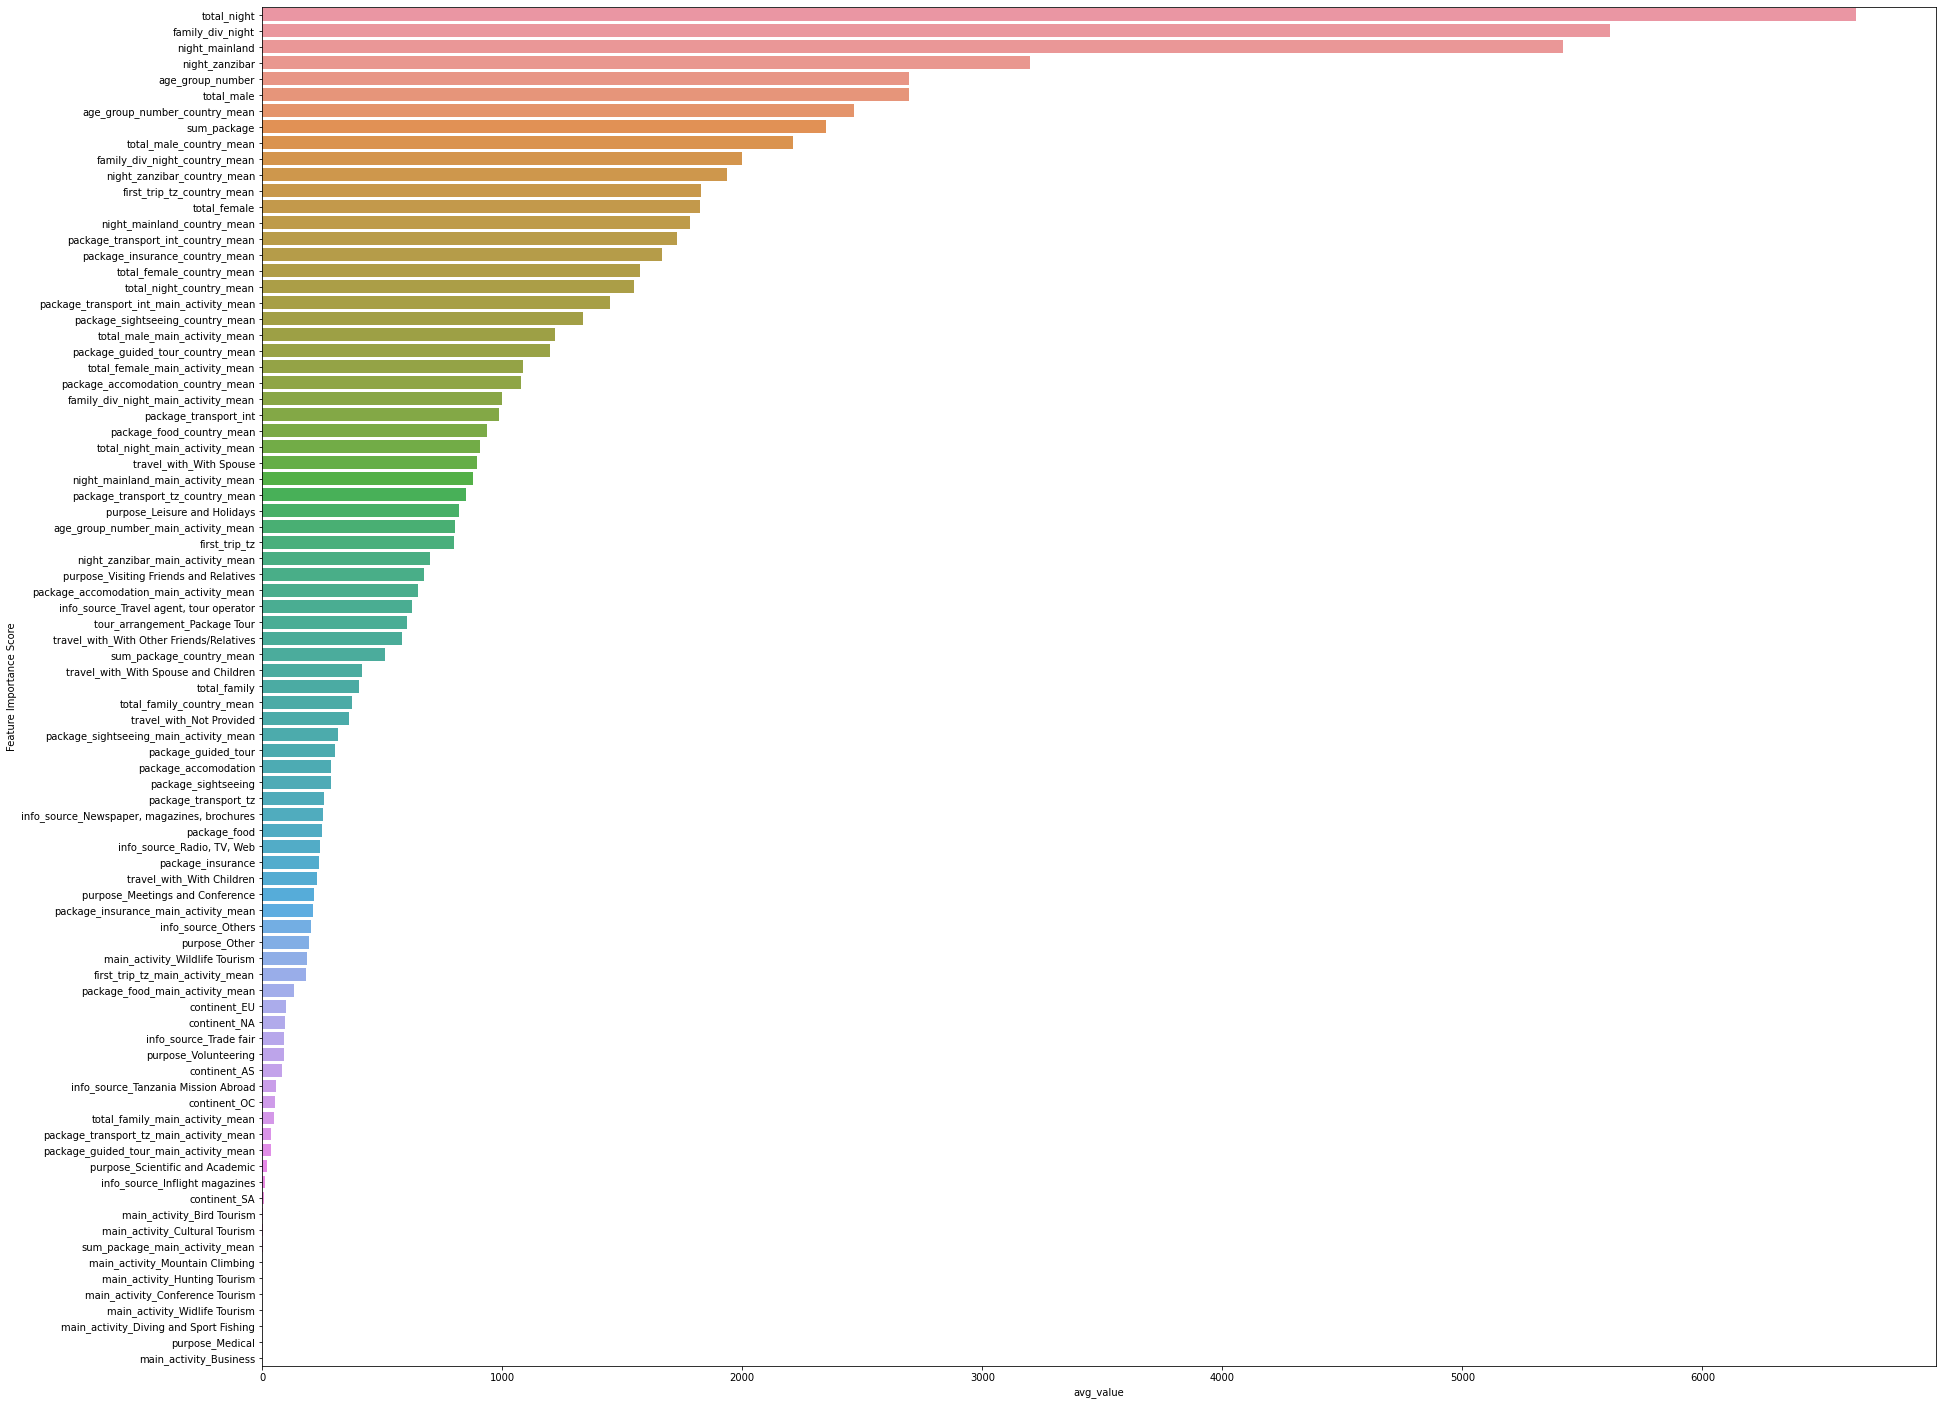

In [17]:
plt.figure(figsize=(30, 25))
sns.barplot(x="avg_value", y="Feature", data=feat_imp.sort_values(by="avg_value", ascending=False))
plt.ylabel('Feature Importance Score')
plt.show()

### **CATBOOST**

In [18]:
res_cat_train = np.zeros(shape=(len(train), len(target.unique())))
res_cat = np.zeros(shape=(len(test), len(target.unique())))
feat_imp = pd.DataFrame(train.columns, columns=['Feature'])

fold = 10
seeds = [42]
for seed in seeds:
  skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
  for n, (tr_ind, te_ind) in enumerate(skf.split(train, target)):

    inp_tr, inp_val, y_tr, y_val = train.iloc[tr_ind], train.iloc[te_ind], target[tr_ind], target[te_ind]
    print(n+1, inp_tr.shape, inp_val.shape, test.shape)

    params = {'l2_leaf_reg': 3.432269727969335, 'max_bin': 273, 'learning_rate': 0.03, 'max_depth': 7, 'min_data_in_leaf': 199}
    model = CatBoostClassifier(
        thread_count=-1,
        n_estimators=8192,
        random_seed=2020,
        **params
        )
    
    model.fit(inp_tr, y_tr, eval_set=(inp_val, y_val), early_stopping_rounds=128, verbose=False, use_best_model=True)
    val_pred = model.predict_proba(inp_val)
    print(f'Log Loss fold {n+1}: {log_loss(y_val, val_pred)}')
    res_cat_train[te_ind] += model.predict_proba(inp_val) / len(seeds)
    res_cat += model.predict_proba(test) / (len(seeds) * fold)
    feat_imp_tmp = pd.DataFrame(sorted(zip(model.feature_importances_, inp_tr.columns)), columns=[f'Value_fold{n+1}','Feature'])
    feat_imp = pd.merge(feat_imp, feat_imp_tmp, on='Feature', how = 'left')

feat_imp['avg_value'] = np.mean(feat_imp[[c for c in feat_imp.columns if 'Value_fold' in c]].values, axis=-1)
feat_imp = feat_imp.sort_values('avg_value').reset_index(drop=True)
print('-' * 50 )
print(f'Seed {seed}, Log Loss oof: {log_loss(target, res_cat_train)}')
print('-' * 50 )

res_cat_train = pd.DataFrame(res_cat_train, columns=['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost'])
res_cat_train.to_csv(save_path + "catboost_train.csv", index=False)

sub[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost']] = res_cat
sub.to_csv(save_path + "catboost.csv", index=False)
sub.to_csv("catboost.csv", index=False)
sub.head(5)

1 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 1: 1.0437998350208297
2 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 2: 1.0351242926170754
3 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 3: 1.0392493316867844
4 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 4: 1.0638906702940154
5 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 5: 1.0768376783080496
6 (16655, 85) (1851, 85) (6169, 85)
Log Loss fold 6: 1.058147767105073
7 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 7: 1.0560350944975758
8 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 8: 1.0843809955026587
9 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 9: 1.0746720374446879
10 (16656, 85) (1850, 85) (6169, 85)
Log Loss fold 10: 1.053886048809231
--------------------------------------------------
Seed 42, Log Loss oof: 1.0586005073735059
--------------------------------------------------


Tour_ID  High Cost  Higher Cost  Highest Cost  Low Cost  \
0  tour_idynufedne   0.116456     0.047623      0.000484  0.052062   
1  tour_id9r3y5moe   0.236870     0.505067      0.018074  0.010741   
2  tour_idf6itml6g   0.739683     0.134408      0.002245  0.006597   
3  tour_id99u4znru   0.043823     0.018932      0.000230  0.251853   
4  tour_idj4i9urbx   0.023344     0.007398      0.000147  0.253891   

   Lower Cost  Normal Cost  
0    0.028210     0.755166  
1    0.020816     0.208432  
2    0.002717     0.114350  
3    0.123911     0.561252  
4    0.305726     0.409494

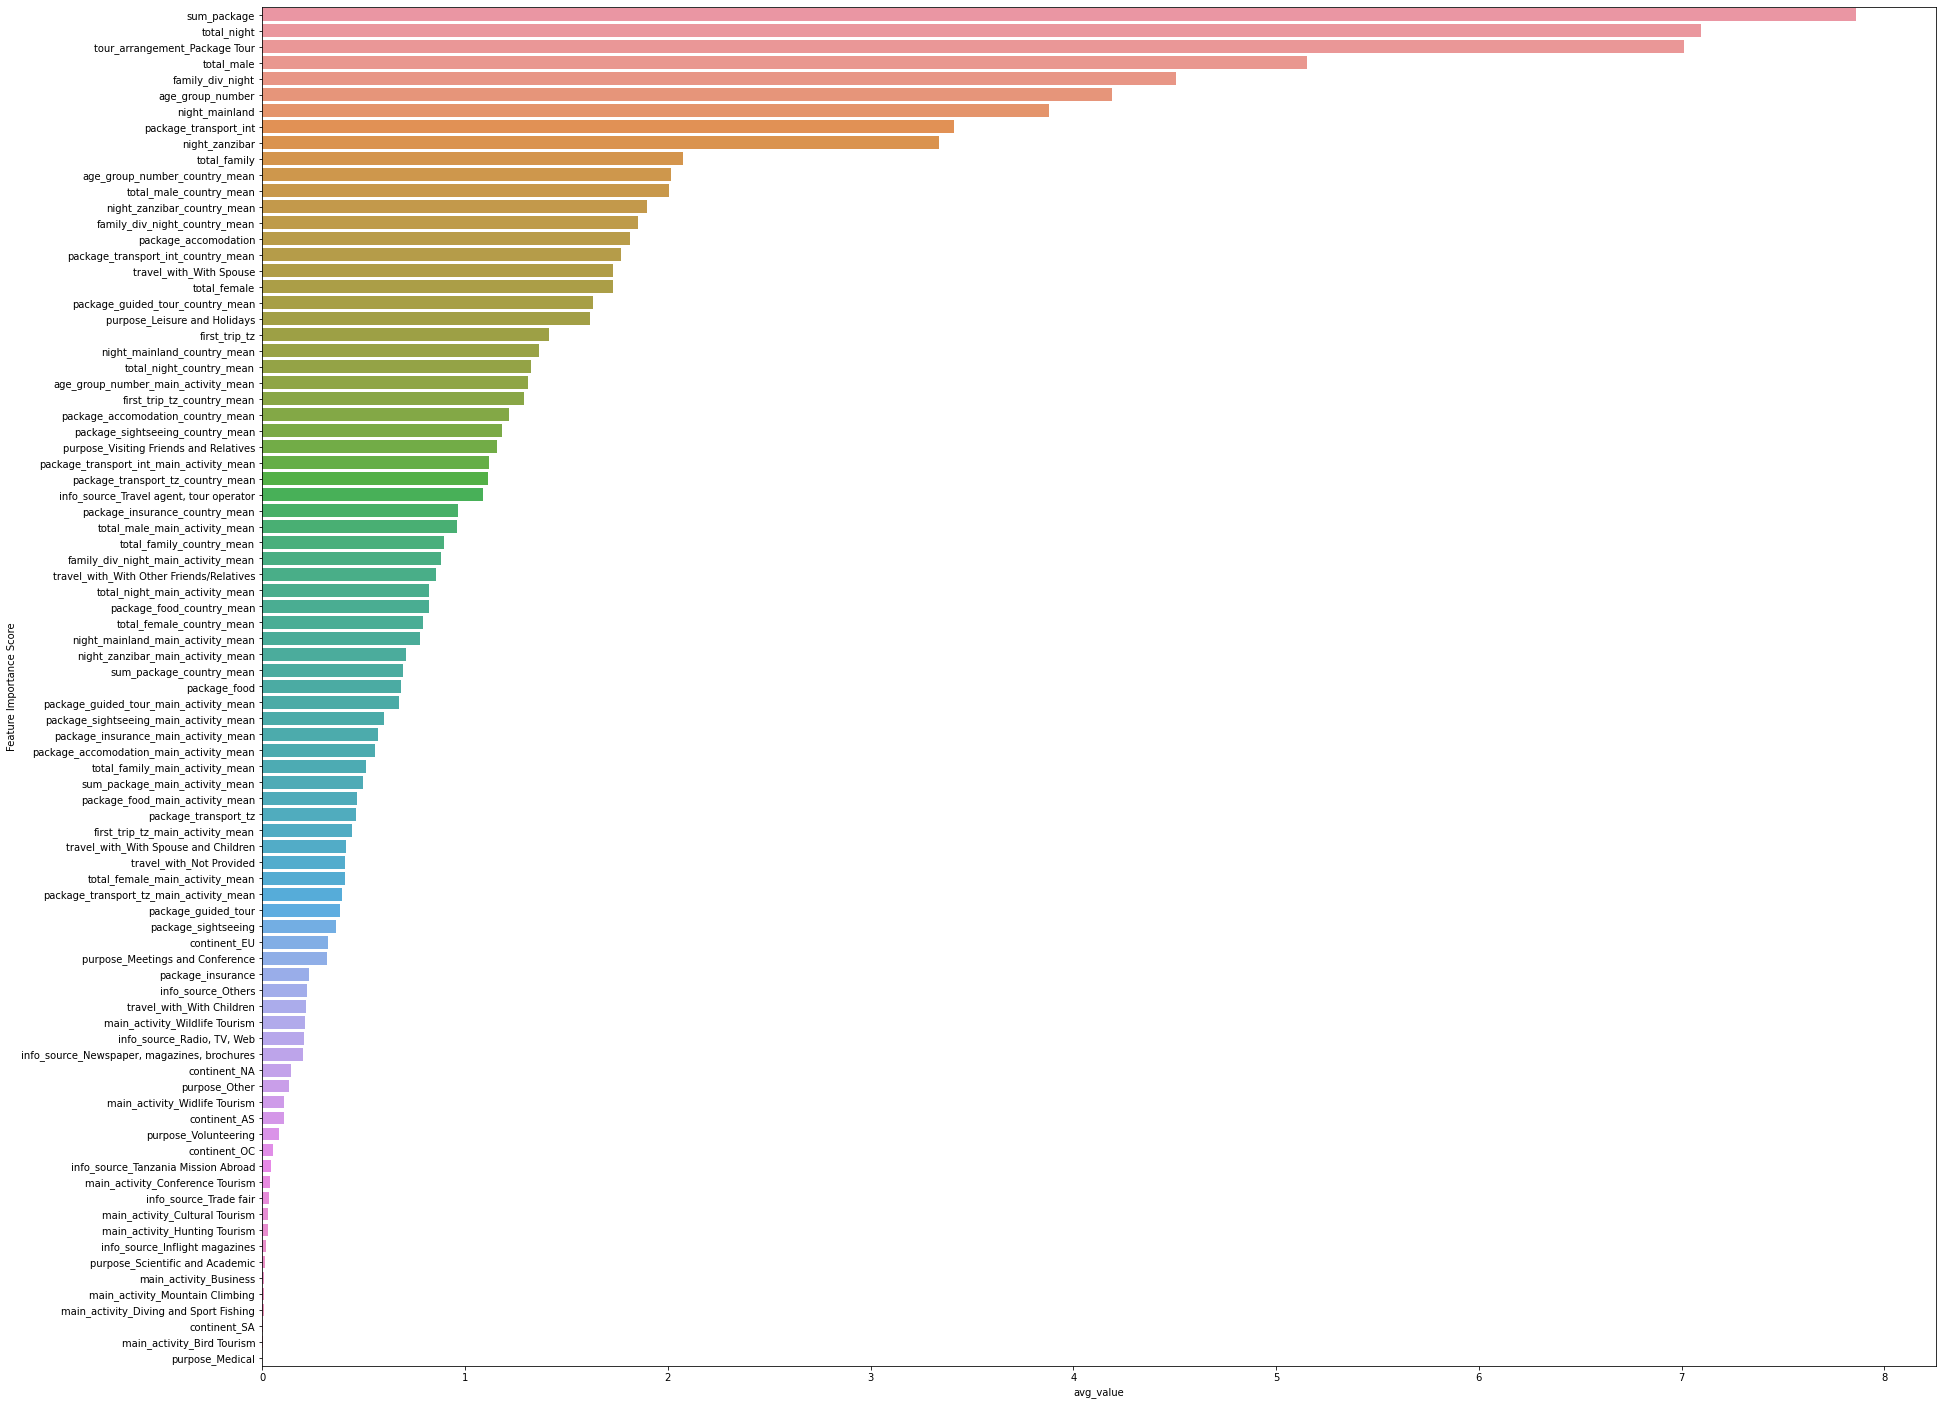

In [19]:
plt.figure(figsize=(30, 25))
sns.barplot(x="avg_value", y="Feature", data=feat_imp.sort_values(by="avg_value", ascending=False))
plt.ylabel('Feature Importance Score')
plt.show()

# **STACKING**

In [20]:
res_lgbm_train = pd.read_csv(save_path + "lgbm_train.csv").values
res_cat_train = pd.read_csv(save_path + "catboost_train.csv").values

## **WEIGHT AVG**

In [21]:
max = np.inf
for i in range(0, 100, 2):
  for j in range(0, 100, 2): 
    if i+j == 100:
      i = i/100
      j = j/100
      pred_stack_W_train = (res_lgbm_train * i + res_cat_train * j)
      score = log_loss(target, pred_stack_W_train)
      if score < max:
        max = score
        best_i = i
        best_j = j
        print(f'{i,j} log_loss: {score}')
print('max:', max, best_i, best_j)

pred_stack_W_train = (res_lgbm_train * best_i + res_cat_train * best_j)
print(f'W Log loss:\n\n{log_loss(target, pred_stack_W_train)}')
pred_stack_W = (res_lgbm * best_i + res_cat * best_j)

sub[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost']] = pred_stack_W
sub.to_csv(save_path + "weight_avg.csv", index=False)
sub.to_csv("weight_avg.csv", index=False)
sub

(0.02, 0.98) log_loss: 1.0583707026038451
(0.04, 0.96) log_loss: 1.0581543888254967
(0.06, 0.94) log_loss: 1.0579510109468915
(0.08, 0.92) log_loss: 1.05776016659677
(0.1, 0.9) log_loss: 1.0575815465937854
(0.12, 0.88) log_loss: 1.05741490327895
(0.14, 0.86) log_loss: 1.0572600322613654
(0.16, 0.84) log_loss: 1.0571167612026326
(0.18, 0.82) log_loss: 1.0569849425575546
(0.2, 0.8) log_loss: 1.0568644486677643
(0.22, 0.78) log_loss: 1.0567551683228253
(0.24, 0.76) log_loss: 1.0566570042747392
(0.26, 0.74) log_loss: 1.0565698713944023
(0.28, 0.72) log_loss: 1.0564936952742872
(0.3, 0.7) log_loss: 1.056428411150315
(0.32, 0.68) log_loss: 1.0563739630581819
(0.34, 0.66) log_loss: 1.0563303031661675
(0.36, 0.64) log_loss: 1.0562973912439506
(0.38, 0.62) log_loss: 1.0562751942386257
(0.4, 0.6) log_loss: 1.0562636859371184
(0.42, 0.58) log_loss: 1.05626284669981
max: 1.05626284669981 0.42 0.58
W Log loss:

1.05626284669981


Tour_ID  High Cost  Higher Cost  Highest Cost  Low Cost  \
0     tour_idynufedne   0.118582     0.051559      0.000574  0.049696   
1     tour_id9r3y5moe   0.234442     0.538901      0.015472  0.010426   
2     tour_idf6itml6g   0.724656     0.139149      0.002471  0.007579   
3     tour_id99u4znru   0.049651     0.020036      0.000388  0.263981   
4     tour_idj4i9urbx   0.023568     0.007984      0.000277  0.258083   
...               ...        ...          ...           ...       ...   
6164  tour_id2deyfjhq   0.012229     0.003078      0.000219  0.298903   
6165  tour_idlenv2rio   0.043145     0.016601      0.000761  0.123143   
6166  tour_id7wwqrs0p   0.392212     0.218451      0.003477  0.014947   
6167  tour_idx80vbw5a   0.111017     0.014968      0.000501  0.182995   
6168  tour_id8fkkwytb   0.009905     0.006086      0.000261  0.237136   

      Lower Cost  Normal Cost  
0       0.030258     0.749332  
1       0.022138     0.178620  
2       0.003606     0.122538  
3       0.116299     0.549644  
4       0.294485     0.415603  
...          ...          ...  
6164    0.510703     0.174868  
6165    0.545622     0.270728  
6166    0.019544     0.351369  
6167    0.133355     0.557165  
6168    0.444371     0.302240  

[6169 rows x 7 columns]

## **META MODEL**

In [22]:
stack = np.column_stack((res_lgbm_train, res_cat_train))
stack_p = np.column_stack((res_lgbm, res_cat))

In [25]:
res_meta_lgbm_train = np.zeros(shape=(len(stack), len(target.unique())))
res_meta_lgbm = np.zeros(shape=(len(stack_p), len(target.unique())))

fold = 10
seeds = [42]
for seed in seeds:
  skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
  for n, (tr_ind, te_ind) in enumerate(skf.split(stack, target)):

    inp_tr, inp_val, y_tr, y_val = stack[tr_ind], stack[te_ind], target[tr_ind], target[te_ind]
    print(n+1, inp_tr.shape, inp_val.shape, stack_p.shape)
    params = {'learning_rate': 0.1, 'num_leaves': 12, 'max_depth': 2, 'feature_fraction': 0.9136313772981607, 'bagging_fraction': 0.8256180490915833, 'bagging_freq': 2, 'min_child_samples': 78}
    model = LGBMClassifier(random_seed=0, **params)  
    
    model.fit(inp_tr, y_tr, eval_set=(inp_val, y_val), early_stopping_rounds=32, verbose=False)
    val_pred = model.predict_proba(inp_val)
    print(f'Log Loss fold {n+1}: {log_loss(y_val, val_pred)}')
    res_meta_lgbm_train[te_ind] += model.predict_proba(inp_val) / len(seeds)
    res_meta_lgbm += model.predict_proba(stack_p) / (len(seeds) * fold)

print(f'Seed {seed}, Log Loss oof: {log_loss(target, res_meta_lgbm_train)}')

sub[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost']] = res_meta_lgbm
sub.to_csv(save_path + "meta_lgbm.csv", index=False)
sub.to_csv("meta_lgbm.csv", index=False)
sub.head(5)

1 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 1: 1.0412035141275837
2 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 2: 1.0340866152302903
3 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 3: 1.0316902797229197
4 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 4: 1.0555185826725035
5 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 5: 1.070973826042899
6 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 6: 1.05384067439547
7 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 7: 1.0548798013560878
8 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 8: 1.0813134286811399
9 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 9: 1.0687370983121256
10 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 10: 1.0518468583302225
Seed 42, Log Loss oof: 1.0544069528479405


Tour_ID  High Cost  Higher Cost  Highest Cost  Low Cost  \
0  tour_idynufedne   0.125902     0.045949      0.001594  0.079635   
1  tour_id9r3y5moe   0.226590     0.579126      0.018632  0.012122   
2  tour_idf6itml6g   0.715651     0.136880      0.002664  0.005414   
3  tour_id99u4znru   0.047911     0.019476      0.000480  0.250176   
4  tour_idj4i9urbx   0.022356     0.005386      0.000540  0.291568   

   Lower Cost  Normal Cost  
0    0.048962     0.697958  
1    0.018440     0.145090  
2    0.007061     0.132331  
3    0.121523     0.560434  
4    0.316144     0.364006

In [26]:
res_meta_cat_train = np.zeros(shape=(len(stack), len(target.unique())))
res_meta_cat = np.zeros(shape=(len(stack_p), len(target.unique())))

fold = 10
seeds = [42]
for seed in seeds:
  skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
  for n, (tr_ind, te_ind) in enumerate(skf.split(stack, target)):

    inp_tr, inp_val, y_tr, y_val = stack[tr_ind], stack[te_ind], target[tr_ind], target[te_ind]
    print(n+1, inp_tr.shape, inp_val.shape, stack_p.shape)

    model = CatBoostClassifier(random_seed=0)
    
    model.fit(inp_tr, y_tr, eval_set=(inp_val, y_val), early_stopping_rounds=32, verbose=False, use_best_model=True)
    val_pred = model.predict_proba(inp_val)
    print(f'Log Loss fold {n+1}: {log_loss(y_val, val_pred)}')
    res_meta_cat_train[te_ind] += model.predict_proba(inp_val) / len(seeds)
    res_meta_cat += model.predict_proba(stack_p) / (len(seeds) * fold)

print(f'Seed {seed}, Log Loss oof: {log_loss(target, res_meta_cat_train)}')

sub[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost']] = res_meta_cat
sub.to_csv(save_path + "meta_cat.csv", index=False)
sub.to_csv("meta_cat.csv", index=False)
sub.head(5)

1 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 1: 1.036762947075474
2 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 2: 1.0302577515083309
3 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 3: 1.0339292041508306
4 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 4: 1.059391150462215
5 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 5: 1.0698975401815933
6 (16655, 12) (1851, 12) (6169, 12)
Log Loss fold 6: 1.051823806753241
7 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 7: 1.0566078870643458
8 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 8: 1.0842243145404407
9 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 9: 1.0658513536154022
10 (16656, 12) (1850, 12) (6169, 12)
Log Loss fold 10: 1.0573233370162238
Seed 42, Log Loss oof: 1.0546044662963965


Tour_ID  High Cost  Higher Cost  Highest Cost  Low Cost  \
0  tour_idynufedne   0.141124     0.033124      0.001189  0.084882   
1  tour_id9r3y5moe   0.267012     0.543906      0.016475  0.012815   
2  tour_idf6itml6g   0.761736     0.110256      0.003870  0.003705   
3  tour_id99u4znru   0.048370     0.011253      0.000438  0.246627   
4  tour_idj4i9urbx   0.021058     0.004046      0.000329  0.304633   

   Lower Cost  Normal Cost  
0    0.048528     0.691153  
1    0.024762     0.135030  
2    0.004477     0.115957  
3    0.116332     0.576980  
4    0.289805     0.380129

## **FINAL**

In [28]:
final_pred = (pred_stack_W + res_meta_cat + res_meta_lgbm) / 3
sub[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost', 'Lower Cost', 'Normal Cost']] = final_pred
sub.to_csv(save_path + "final_sub.csv", index=False)
sub.to_csv("final_sub.csv", index=False)
sub.head(5)

Tour_ID  High Cost  Higher Cost  Highest Cost  Low Cost  \
0  tour_idynufedne   0.128536     0.043544      0.001119  0.071404   
1  tour_id9r3y5moe   0.242681     0.553978      0.016860  0.011788   
2  tour_idf6itml6g   0.734014     0.128762      0.003002  0.005566   
3  tour_id99u4znru   0.048644     0.016922      0.000435  0.253595   
4  tour_idj4i9urbx   0.022327     0.005805      0.000382  0.284761   

   Lower Cost  Normal Cost  
0    0.042583     0.712814  
1    0.021780     0.152914  
2    0.005048     0.123609  
3    0.118052     0.562353  
4    0.300144     0.386580